### 1. YOLOv8 模型转换为 OpenVINO专用模型步骤

#### 准备模型
- **下载YOLOv8 PyTorch模型**：确保YOLOv8模型已下载并准备好进行转换。

#### 转换模型为OpenVINO IR格式
- **安装OpenVINO工具包**：确保系统中已安装OpenVINO工具包。
- **导出PyTorch模型为ONNX格式**：
  ```python
  import torch
  import onnx
  from ultralytics import YOLO

  # Load YOLOv8 model
  model = YOLO('yolov8.pt')

  # Export the model to ONNX format
  dummy_input = torch.randn(1, 3, 640, 640)
  torch.onnx.export(model, dummy_input, 'yolov8.onnx', opset_version=11)
  ```
- **使用Model Optimizer将ONNX模型转换为OpenVINO IR格式**：
  ```sh
  mo --input_model yolov8.onnx --output_dir openvino_model --input_shape [1,3,640,640]
  ```
  

### 2. 在OpenVINO中加载转换好的YOLO模型

#### 加载模型
- **导入OpenVINO推理引擎**：
  ```python
  from openvino.runtime import Core

  # Initialize OpenVINO runtime
  core = Core()
  model_path = "openvino_model/yolov8.xml"

  # Read the model
  model = core.read_model(model=model_path)
  ```
- **编译模型**：
  ```python
  # Compile the model for the desired device (e.g., CPU, GPU)
  compiled_model = core.compile_model(model=model, device_name="CPU")
  ```

# パッケージを導入します。

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from openvino.runtime import Core

import time

# OpenVINOモデルを読み込み、コンパイルと画像の読み込み

In [2]:

# Load the OpenVINO runtime
core = Core()

# Read the OpenVINO model
model_path = "models/openvino_model/yolov8s.xml"
model = core.read_model(model_path)

# Compile the model
compiled_model = core.compile_model(model, "CPU")

# Get input and output layers
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

# Load an image
image = cv2.imread('data/human_cat_dog2.jpg')
image = cv2.resize(image, (640, 640))


# OpenVINOを利用し、推論すること。

In [3]:
# Preprocess the image: resize, convert to blob, etc.
blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(640, 640), mean=(0, 0, 0), swapRB=True, crop=False)

# Perform forward pass
outputs = compiled_model([blob])[output_layer]

# 推論した結果の処理

In [4]:
def postprocess(outputs, img):
    boxes = []
    confidences = []
    class_ids = []

    outputs = outputs[0]  # Remove the batch dimension
    for detection in outputs.T:  # Transpose to iterate over detections
        class_scores = detection[4:]
        class_id = np.argmax(class_scores)
        confidence = class_scores[class_id]
        if confidence > 0.3:
            cx, cy, w, h = detection[:4]
            box = np.array([cx - w / 2, cy - h / 2, cx + w / 2,  cy + h / 2])
            box = box.astype("int")
            boxes.append(box)
            confidences.append(float(confidence))
            class_ids.append(class_id)

    return boxes, confidences, class_ids


# 推論した画像の表示すること

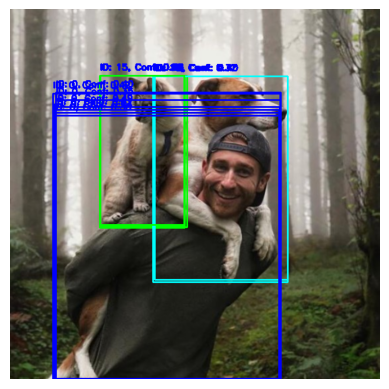

In [5]:
# Process the outputs
boxes, confidences, class_ids = postprocess(outputs, image)

# Copy an image
copy_image = image.copy()

# Draw the bounding boxes on the image
for box, confidence, class_id in zip(boxes, confidences, class_ids):
    if class_id == 0:
        cv2.rectangle(copy_image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    if class_id == 15:  # COCO cat
        cv2.rectangle(copy_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    if class_id == 16:  # COCO dog
        cv2.rectangle(copy_image, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 2)

    label = f'ID: {class_id}, Conf: {confidence:.2f}'
    cv2.putText(copy_image, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


# Display the image
plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# OpenCVのNMSを利用してみます

OpenCV NMS took 0.00000000 seconds


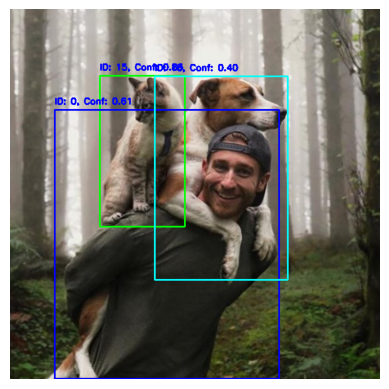

In [6]:
# Process the outputs
boxes, confidences, class_ids = postprocess(outputs, image)

# Copy an image
copy_image = image.copy()

# Use the NMS from OpenCV
start = time.time()
indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.3, nms_threshold=0.5)
print(f"OpenCV NMS took {time.time() - start:.8f} seconds")

# Draw the bounding boxes on the image
for i in indices:
    box = boxes[i]
    class_id = class_ids[i]
    confidence = confidences[i]

    if class_id == 0:
        cv2.rectangle(copy_image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    if class_id == 15:  # COCO cat
        cv2.rectangle(copy_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    if class_id == 16:  # COCO dog
        cv2.rectangle(copy_image, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 2)

    label = f'ID: {class_id}, Conf: {confidence:.2f}'
    cv2.putText(copy_image, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display the image
plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()